In [1]:
from pathlib import Path
import os
import pandas as pd
import sys
import requests
from functools import partial
from tqdm import tqdm

import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch 
from einops import rearrange, repeat
from loguru import logger
from torchmetrics import Metric, BootStrapper
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import seaborn as sns
import statannotations
from statannotations.Annotator import Annotator
from matplotlib.pyplot import figure
from cka import gram, centering_mat, centered_gram, unbiased_hsic_xy, MinibatchCKA, HookedCache, make_pairwise_metrics, update_metrics, get_simmat_from_metrics
import numpy as np
import re

import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import timm
from timm.utils import accuracy
from torch.utils.tensorboard import SummaryWriter

from get_models import get_model

writer = SummaryWriter()

DEVICE = torch.device('cpu')
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')

## Compare finetuning dynamics

In [2]:
from ast import literal_eval

In [3]:
results = {'DINO': [], 'MoCoV3': [], 'MAE': []}

In [4]:
for key in results:
    folder_name = "../checkpoints/" + key.lower() + "-ft-all/SLURM/"
    log_file = folder_name + "ft_log.txt"

    log_list = []
    print(log_file)
    if os.path.isfile(log_file): 
        with open(log_file, "r") as log:
            for line in log:
                log_dict = literal_eval(line)
                log_list.append(log_dict)
               
    df = pd.DataFrame(log_list)
    df = df.set_index('epoch')
    df = df[~df.index.duplicated(keep='first')]
    results[key] = df

../checkpoints/dino-ft-all/SLURM/ft_log.txt
../checkpoints/mocov3-ft-all/SLURM/ft_log.txt
../checkpoints/mae-ft-all/SLURM/ft_log.txt


In [5]:
module_cols = [col for col in results['MAE'].columns if ('module.' in col and 'head' not in col)]

In [6]:
distances = pd.read_csv('PT_to_FT_dist_ICML.csv')
distances.rename(columns={'MoCo-V3':'MoCoV3'}, inplace=True)

In [7]:
print(len(module_cols))
print(len(distances))

112
112


In [8]:
for key in results:
    results[key]['change_lr'] = results[key]['train_norm_params_change'] / results[key]['train_lr']
    results[key]['change_lr_cumsum'] = results[key]['change_lr'].cumsum()
    results[key]['train_norm_params_change_cumsum'] = results[key]['train_norm_params_change'].cumsum()

    results[key].rename(columns={"change_lr": "L2-norm ΔParameters (LR scaled)", "train_norm_params_change": "L2-norm ΔParameters", "train_norm_params_after_update": 
                                "L2-norm Parameters", "change_lr_cumsum": "L2-norm ΔParameters (LR scaled, Cumulative Sum)", "train_norm_params_change_cumsum": 
                                "L2-norm ΔParameters (Cumulative Sum)"}, inplace=True)

    results[key]['L2-norm ΔParameters / L2-norm Parameters'] = results[key]['L2-norm ΔParameters'] / results[key]['L2-norm Parameters']
    results[key]['L2-norm ΔParameters / L2-norm Parameters (converged)'] = results[key]['L2-norm ΔParameters'] / results[key]['L2-norm Parameters'].iloc[-1]
    results[key]['L2-norm ΔParameters / L2-norm Parameters (initial)'] = results[key]['L2-norm ΔParameters'] / results[key]['L2-norm Parameters'].iloc[0]
    

In [9]:
for key in results:
    for module in module_cols:
        layer_name = module.split('train_module.')[-1]
        results[key][module+'_cumsum'] = results[key][module].cumsum()
        results[key][module+'_scaled'] = distances.loc[distances.layer==layer_name, key].item() / results[key][module] 
        results[key][module+'_scaled_cumsum'] = results[key][module+'_scaled'].cumsum()

In [10]:
path_ratio = {}

for key in results:
    path_ratio[key] = {}
    for module in module_cols:
        layer_name = module.split('train_module.')[-1]
        
        path_ratio[key][module] = results[key][module].sum()
        path_ratio[key][module] = path_ratio[key][module] / distances.loc[distances.layer==layer_name, key].item()
        
        print(key, module, path_ratio[key][module], 'displacement = ', results[key][module].sum(), 'max displacement = ', results[key][module].max(), ' distance = ', distances.loc[distances.layer==layer_name, key].item())

DINO train_module.patch_embed 0.37025335197714215 displacement =  11.810259061238629 max displacement =  0.15322371183348885  distance =  31.897777557373047
DINO train_module.patch_embed.proj 0.37025335197714215 displacement =  11.810259061238629 max displacement =  0.15322371183348885  distance =  31.897777557373047
DINO train_module.blocks 0.22962912187987247 displacement =  141.92140701690664 max displacement =  1.8828551770209503  distance =  618.0462036132812
DINO train_module.blocks.0 0.25469945134166055 displacement =  37.16763615274003 max displacement =  0.49252370233348997  distance =  145.92742919921875
DINO train_module.blocks.0.norm1 0.12461707845871525 displacement =  0.7110874332599391 max displacement =  0.0102022339725386  distance =  5.706179618835449
DINO train_module.blocks.0.attn 0.30186306111016453 displacement =  24.883472705095716 max displacement =  0.3332626576141583  distance =  82.4329833984375
DINO train_module.blocks.0.attn.qkv 0.29011176172385295 displace

In [11]:
df = pd.DataFrame(path_ratio)
df.reset_index(inplace=True)
df.rename(columns={'index':'Layer'}, inplace=True)
df = df.melt(id_vars=['Layer'], value_name='Path Ratio', var_name='Model')


In [12]:
df

,Layer,Model,Path Ratio
0,train_module.patch_embed,DINO,0.370253
1,train_module.patch_embed.proj,DINO,0.370253
2,train_module.blocks,DINO,0.229629
3,train_module.blocks.0,DINO,0.254699
4,train_module.blocks.0.norm1,DINO,0.124617
...,...,...,...
331,train_module.blocks.11.norm2,MAE,0.021025
332,train_module.blocks.11.mlp,MAE,0.291222
333,train_module.blocks.11.mlp.fc1,MAE,0.372877
334,train_module.blocks.11.mlp.fc2,MAE,0.246075


DINO vs. MoCoV3: t-test independent samples, P_val:4.221e-09 t=9.327e+00
t-test_ind 
t-test_ind 
MoCoV3 vs. MAE: t-test independent samples, P_val:1.348e-13 t=-1.599e+01
t-test_ind 
t-test_ind 
DINO vs. MAE: t-test independent samples, P_val:1.703e-07 t=-7.498e+00
t-test_ind 
t-test_ind 


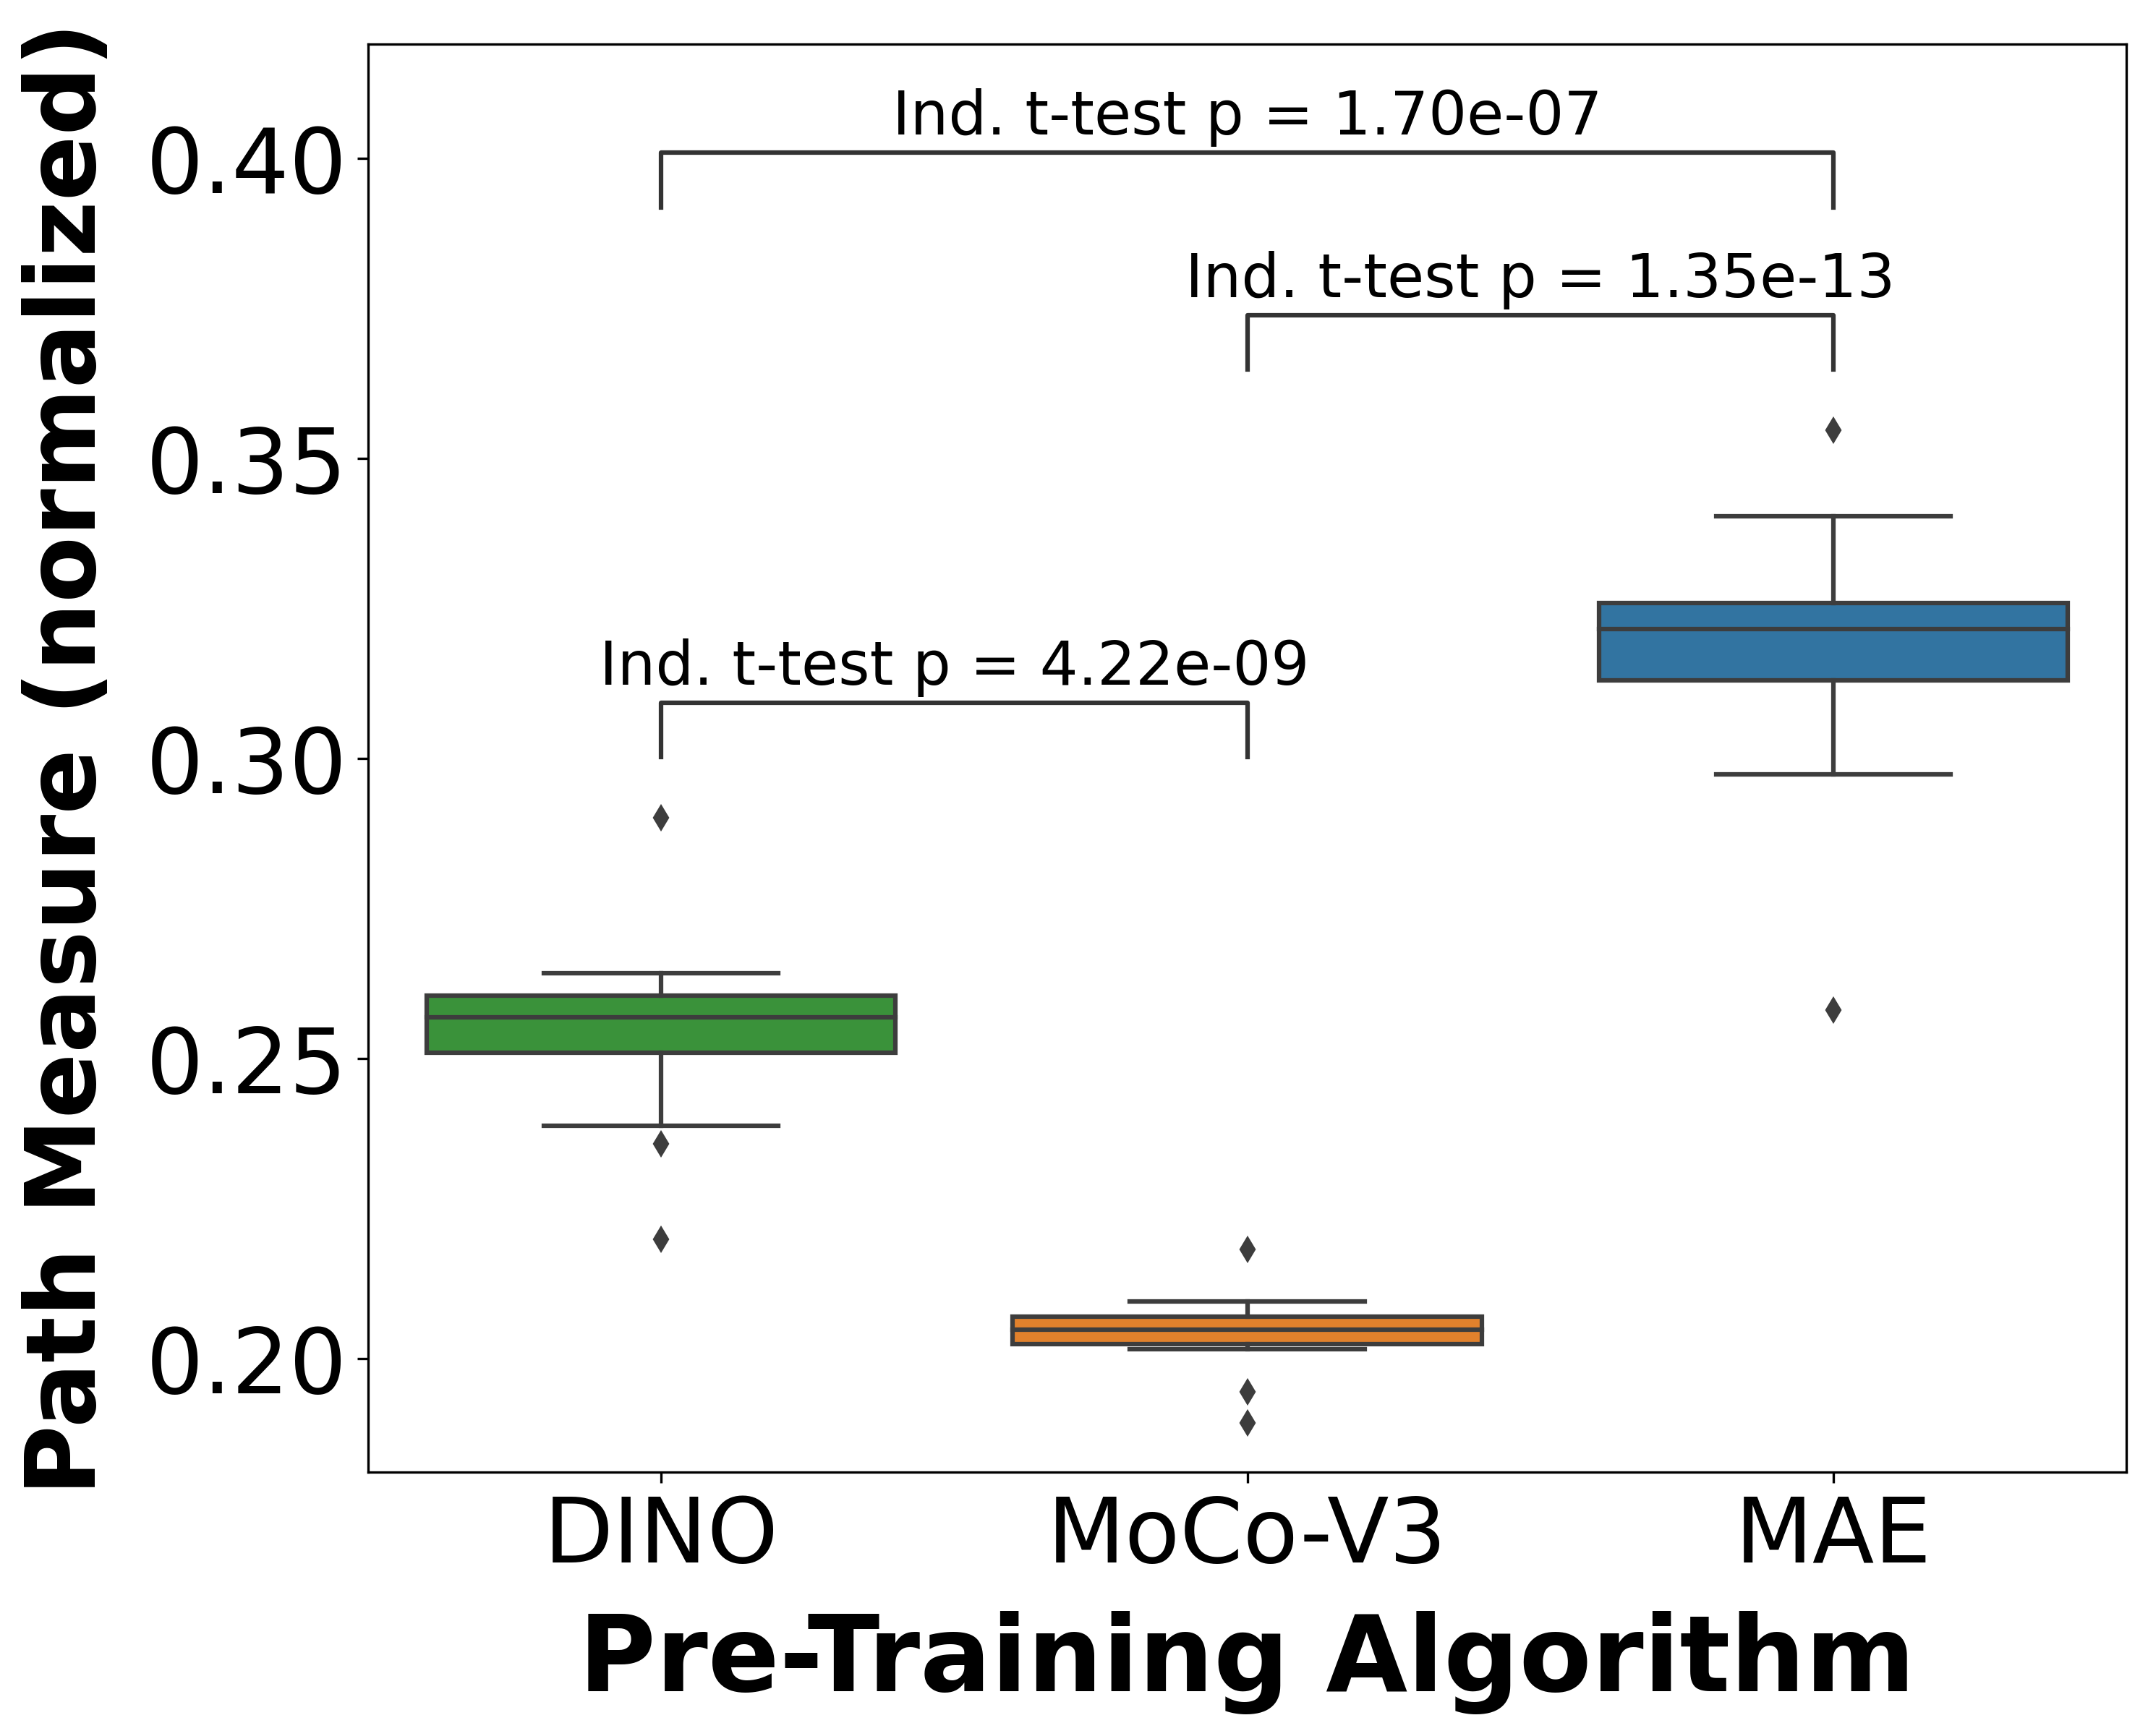

In [25]:
fig_dir = '../figures/ICML/'
fig, ax = plt.subplots(figsize=(10, 8), dpi=300, sharex=True)

data = df[df['Layer'].str.contains('qkv')]
sns.boxplot(data=data, x='Model', y='Path Ratio', ax=ax, palette=['tab:green', 'tab:orange', 'tab:blue'])

annot = Annotator(ax, [("DINO", "MoCoV3"), ("MoCoV3", "MAE"), ("DINO", "MAE")], data=data, x='Model', y='Path Ratio')
annot.configure(test='t-test_ind', text_format='full', loc='inside',
                comparisons_correction=None, line_height=0.05, text_offset=2, fontsize=20)
annot.apply_test().annotate(line_offset_to_group=0.05, line_offset=0.1)

#ax.set_yticks(np.arange(0.20, 0.4, 0.05).append([0.4]), visible=True)
#ax.set_yticklabels([x for x in np.arange(0.20, 0.4, 0.05).append([0.4])], fontsize = 30)
ax.yaxis.set_tick_params(labelsize=30)
ax.set_xticklabels([x for x in ['DINO', 'MoCo-V3', 'MAE']], fontsize = 30)

plt.xlabel("Pre-Training Algorithm", fontweight="bold", fontsize = 35, labelpad=10)
plt.ylabel("Path Measure (normalized)", fontweight="bold", fontsize = 32, labelpad=10)

plt.tight_layout()
plt.savefig(fig_dir+'arxiv_dynamics_path_measure'+'.pdf', dpi=300, bbox_inches = "tight")

plt.show()
